# Importing required libraries

In [ ]:
%pip install statsmodels
%pip install tensorflow
%pip install keras_tuner
%pip install keras
%pip install streamlit


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta
from keras_tuner.tuners import RandomSearch,Hyperband
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pickle

2024-11-27 05:03:42.922079: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 05:03:43.125969: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 05:03:43.241932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732683823.378051    5884 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732683823.413452    5884 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 05:03:43.691448: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Data exploration and preprocessing

In [3]:
# importing the dataset
df=pd.read_csv('AAPL.csv')

In [9]:
# information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2011 non-null   object 
 1   Open       2011 non-null   float64
 2   High       2011 non-null   float64
 3   Low        2011 non-null   float64
 4   Close      2011 non-null   float64
 5   Adj Close  2011 non-null   float64
 6   Volume     2011 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 110.1+ KB


In [4]:
# preview of the data
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
1,2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2,2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
3,2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
4,2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


In [496]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2006,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.054138,24643000
2007,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.322266,12119700
2008,2019-12-26,284.820007,289.980011,284.700012,289.910004,287.923645,23280300
2009,2019-12-27,291.119995,293.970001,288.119995,289.799988,287.814392,36566500
2010,2019-12-30,289.459991,292.690002,285.220001,291.519989,289.522614,36028600


In [4]:
# creating a dataframe considering only closing price
df1=df[['Close',"Date"]]

In [325]:
df1.head()

,Close,Date
0,58.747143,2012-01-03
1,59.062859,2012-01-04
2,59.718571,2012-01-05
3,60.342857,2012-01-06
4,60.247143,2012-01-09


In [8]:
# checking for null values
df1.isnull().sum().sum()

0

- There are no null values

In [499]:
# Description
df1.describe()

,Close
count,2011.000000
mean,126.741235
std,50.578369
min,55.790001
25%,86.202145
50%,113.050003
75%,165.245002
max,291.519989


- From the above description, we can say that there are outliers but outliers often provide valuable information in time series data, especially in financial markets, where they reflect real and impactful events hence we retained the outliers.

In [5]:
# converting the date column into datetime
df1['Date'] = pd.to_datetime(df1['Date'])
# making date as index
df1.set_index('Date', inplace=True)

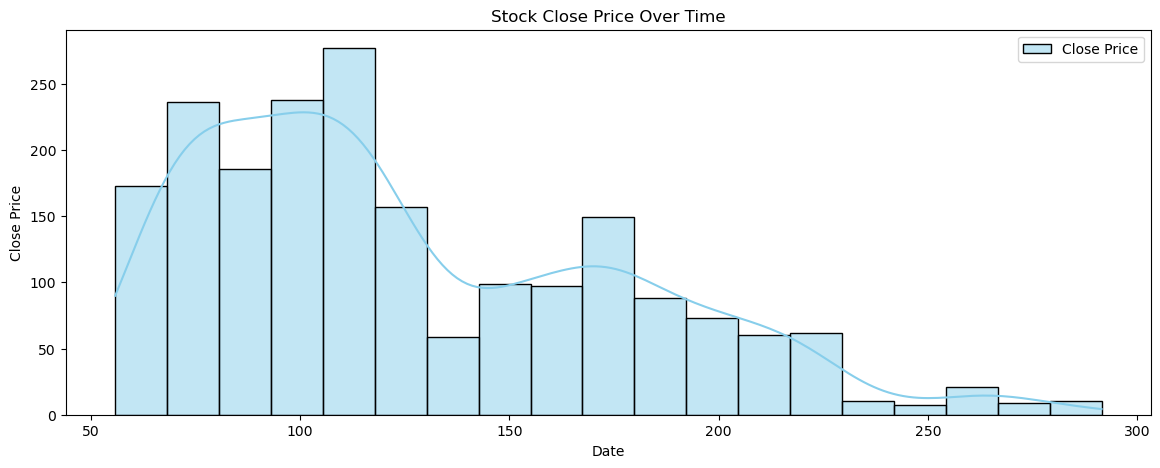

In [18]:
plt.figure(figsize=(14, 5))
sns.histplot(df1['Close'],label='Close Price', kde=True, color='skyblue')
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

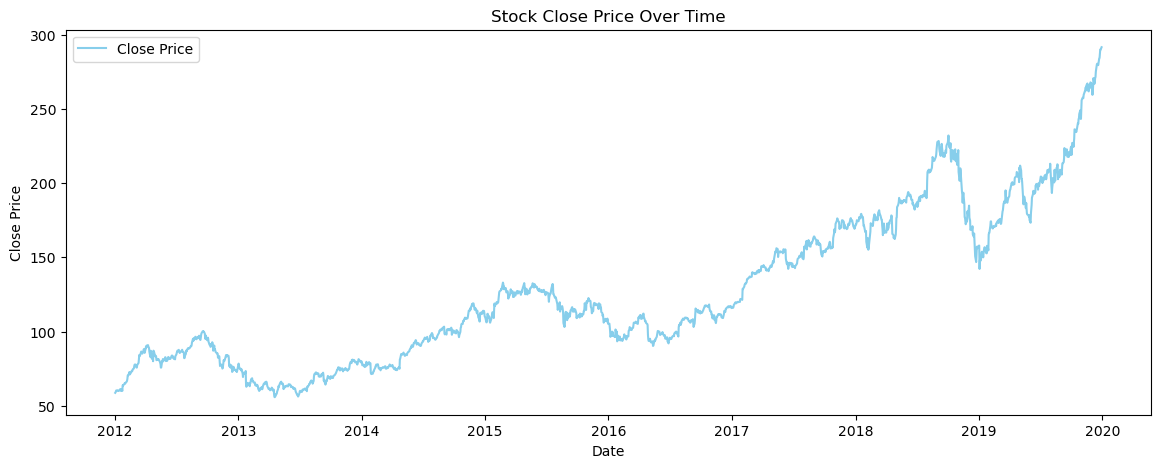

In [522]:
plt.figure(figsize=(14, 5))
sns.lineplot(df1['Close'],label='Close Price', color='skyblue')
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

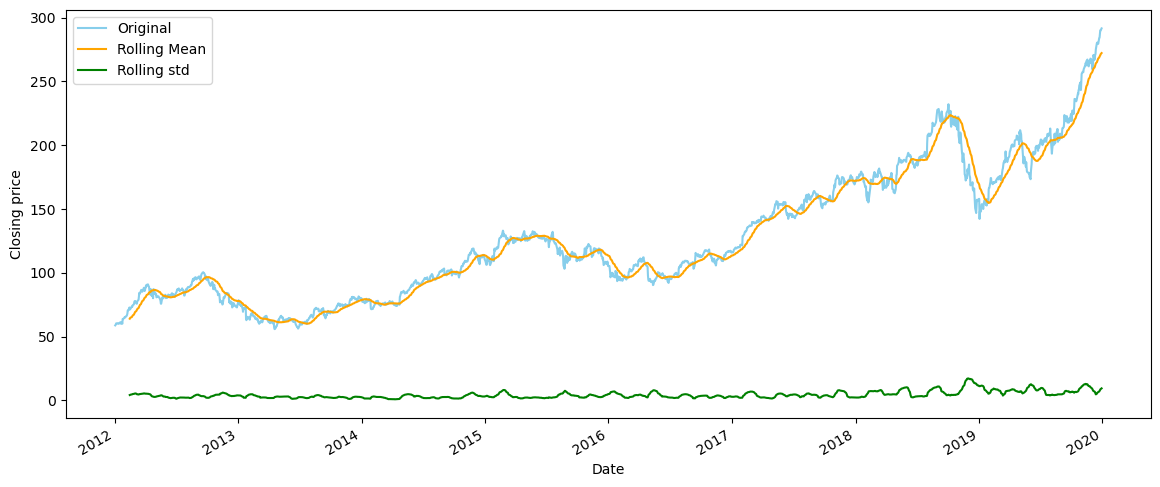

In [527]:
plt.figure(figsize=(14,6))
sns.lineplot(df1['Close'], label='Original', color='skyblue')
df1['Close'][1:].rolling(30).mean().plot(label='Rolling Mean', color='orange')
df1['Close'][1:].rolling(30).std().plot(label='Rolling std ', color='green')
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.legend()
plt.show()

From the analysis above, we can observe the following:   

- Trend: The time series exhibits a trend, indicating that the mean is not constant over time.   
- Variance: The variance appears to be fairly constant over the observed period.    

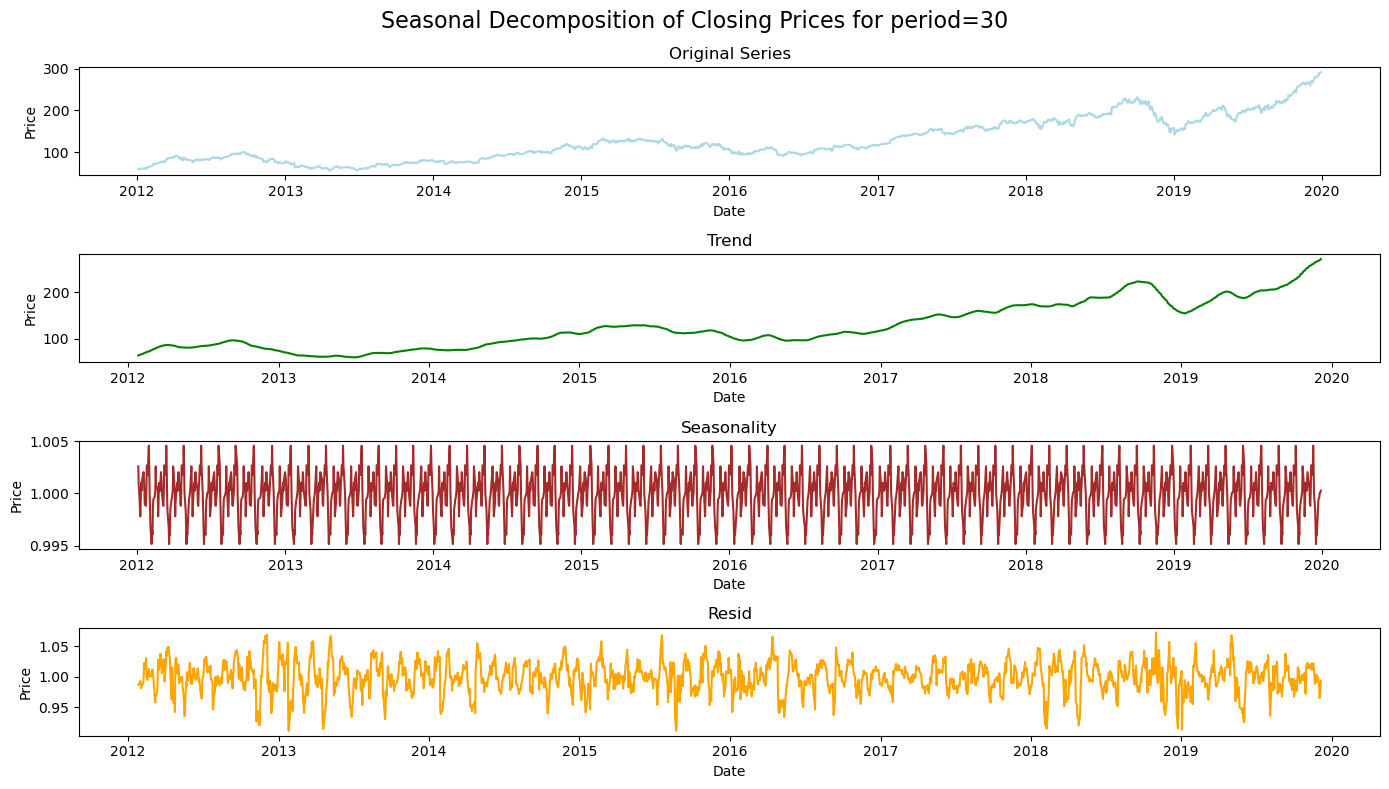

In [319]:
result = seasonal_decompose(df1['Close'], model='multiplicative', period=30)

plt.figure(figsize=(14,8))
plt.suptitle('Seasonal Decomposition of Closing Prices for period=30', fontsize=16)
plt.subplot(4,1,1)
sns.lineplot(x=df1.index, y=df1['Close'], color='lightblue')
plt.title('Original Series')
plt.ylabel('Price')

plt.subplot(4,1,2)
sns.lineplot(x=df1.index, y=result.trend, color='green')
plt.title('Trend')
plt.ylabel('Price')

plt.subplot(4,1,3)
sns.lineplot(x=df1.index, y=result.seasonal, color='brown')
plt.title('Seasonality')
plt.ylabel('Price')

plt.subplot(4,1,4)
sns.lineplot(x=df1.index, y=result.resid, color='orange')
plt.title('Resid')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

**stationarity:**
The main conditions for stationarity are:

*  Constant Mean: The mean (average) of the series should remain stable over time.
*   Constant Variance: The spread (variance) of the series should not change   over time.
*   Constant Covariance: The relationship between values at different time lags should remain consistent.             

Hence, the series is non-stationary. Techniques like differencing or log transformation are often applied to make the data stationary before modeling.

In [506]:
# using augmented dickey fuller test for stationarity check
result = adfuller(df1)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: 1.2193701254377993
p-value: 0.9961170178032009


In [5]:
# first order differencing as the data is non-stationary
df1['diff'] =df1-df1.shift(1)
df1.dropna(inplace=True)

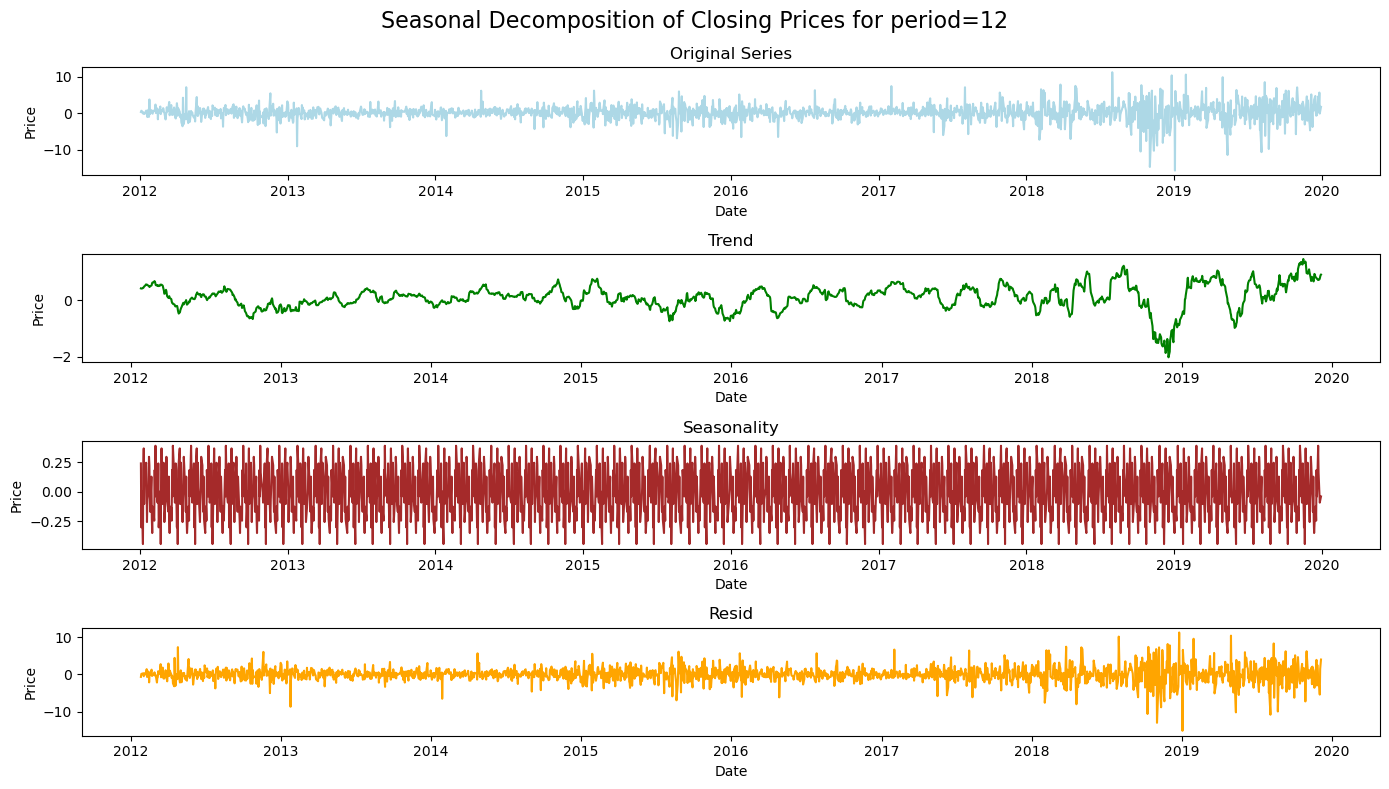

In [320]:
result = seasonal_decompose(df1['diff'], model='add', period=30)

plt.figure(figsize=(14,8))
plt.suptitle('Seasonal Decomposition of Closing Prices for period=12', fontsize=16)
plt.subplot(4,1,1)
sns.lineplot(x=df1.index, y=df1['diff'], color='lightblue')
plt.title('Original Series')
plt.ylabel('Price')

plt.subplot(4,1,2)
sns.lineplot(x=df1.index, y=result.trend, color='green')
plt.title('Trend')
plt.ylabel('Price')

plt.subplot(4,1,3)
sns.lineplot(x=df1.index, y=result.seasonal, color='brown')
plt.title('Seasonality')
plt.ylabel('Price')

plt.subplot(4,1,4)
sns.lineplot(x=df1.index, y=result.resid, color='orange')
plt.title('Resid')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

- The time series shows no trend and displays cyclic behavior; however, the cycles vary in length. As a result, the data is considered stationary.


In [508]:
result = adfuller(df1['diff'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {np.round(result[1],4)}')

ADF Statistic: -13.62553432387323
p-value: 0.0


#### Now the series is stationary

In [509]:
df1.head()

,Close,diff
Date,,
2012-01-04,59.062859,0.315716
2012-01-05,59.718571,0.655712
2012-01-06,60.342857,0.624286
2012-01-09,60.247143,-0.095714
2012-01-10,60.462856,0.215713


#### Plotting autocorrelation (acf) and partial autocorrelation plot (pacf) to choose p, q values

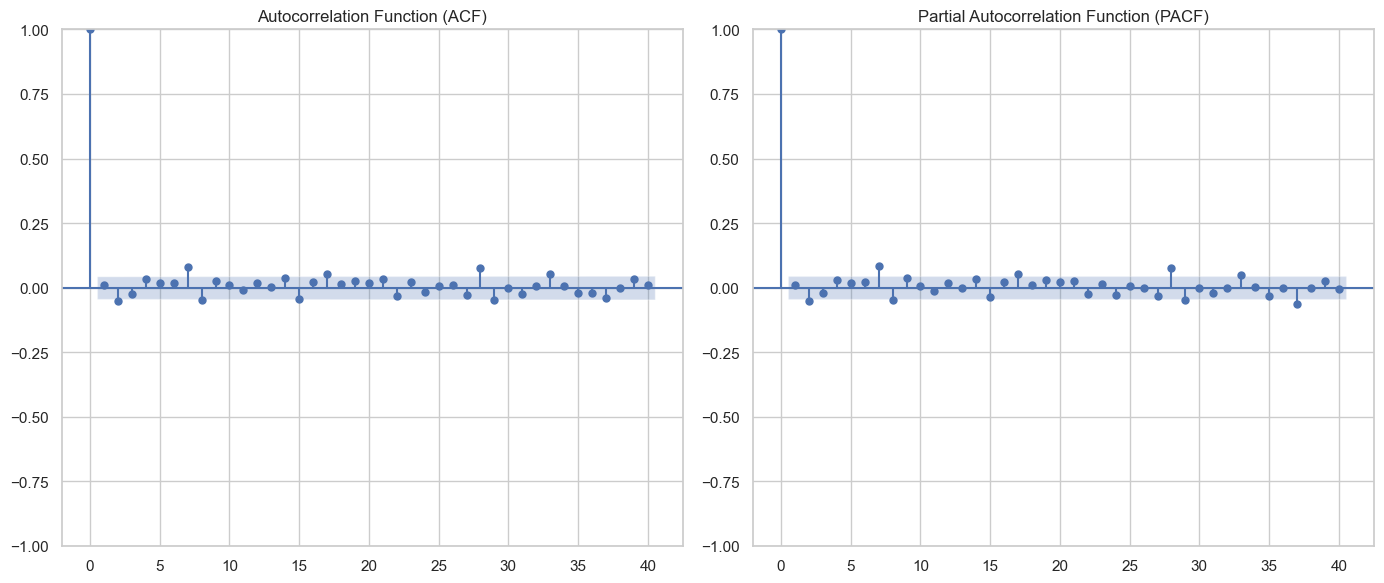

In [562]:
plt.figure(figsize=(14, 6))
# Autocorrelation Plot
plt.subplot(1, 2, 1)
plot_acf(df1['diff'], lags=40, ax=plt.gca()) 
plt.title('Autocorrelation Function (ACF)')

# Partial Autocorrelation Plot
plt.subplot(1, 2, 2)
plot_pacf(df1['diff'], lags=40, ax=plt.gca(), method='ywm') 
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [90]:
# autoregression order from pacf plot
q= 7
# moving-average order from acf plot
p= 7

In [184]:
# train and test split
train=df1.iloc[:-252]
# last year considering as test series without including weekends
test=df1.iloc[-252:]    

In [9]:
train.shape

(1758, 2)

# Model Building

## Arima Model
- Best For: Non-seasonal data with trends.
- Why: ARIMA models are widely used because they capture trends, lags, and relationships within the data through autoregression and moving averages. They’re very effective for stationary data or data that can be made stationary through differencing.
- Limitations: ARIMA does not handle seasonality well without extensions like SARIMA (Seasonal ARIMA), which adds seasonal components.

#### finding the best value for (P,Q,D)

In [563]:
p_values=range(2,8)
q_values=range(2,8)
d_values=range(0,2)
for p in p_values:
    for q in q_values:
        for d in d_values:
            arima_model=ARIMA(train['diff'],order=(p,d,q))
            arima_model=arima_model.fit()
            forecast_steps = 252
            forecast = arima_model.forecast(steps=forecast_steps)
            forecast_org = forecast.cumsum() + df1['Close'].iloc[-252 - 1]
            print(f"{(p,d,q)} RMSE:",root_mean_squared_error(forecast_org,test['Close']))

(2, 0, 2) RMSE: 54.37032965266886
(2, 1, 2) RMSE: 53.93793513013034
(2, 0, 3) RMSE: 54.062423816464936
(2, 1, 3) RMSE: 53.96435422881711
(2, 0, 4) RMSE: 54.341871327477655
(2, 1, 4) RMSE: 53.93820481912413
(2, 0, 5) RMSE: 54.271777986761705
(2, 1, 5) RMSE: 54.652524935155725
(2, 0, 6) RMSE: 54.23936655999803
(2, 1, 6) RMSE: 54.3785707529134
(2, 0, 7) RMSE: 54.71049162740322
(2, 1, 7) RMSE: 54.87515374709896
(3, 0, 2) RMSE: 54.230668593238555
(3, 1, 2) RMSE: 53.91954268402074
(3, 0, 3) RMSE: 54.283932186507684
(3, 1, 3) RMSE: 53.900474284030594
(3, 0, 4) RMSE: 54.85084285430123
(3, 1, 4) RMSE: 53.83551522661193
(3, 0, 5) RMSE: 59.582443513818006
(3, 1, 5) RMSE: 55.69614195557879
(3, 0, 6) RMSE: 58.952956132095075
(3, 1, 6) RMSE: 53.796225341588446
(3, 0, 7) RMSE: 54.47620853410215
(3, 1, 7) RMSE: 131.4590296236542
(4, 0, 2) RMSE: 54.0318249515859
(4, 1, 2) RMSE: 128.85219481318282
(4, 0, 3) RMSE: 68.37564592492018
(4, 1, 3) RMSE: 116.30012427378462
(4, 0, 4) RMSE: 54.23015660472232
(4, 

In [7]:
# from above we can consider
p=7
q=6
d=0 # as we already differenced the data
arima_model=ARIMA(train['diff'],order=(p,d,q))
arima_model=arima_model.fit()
print(arima_model.summary())

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                 1758
Model:                 ARIMA(7, 0, 6)   Log Likelihood               -3619.174
Date:                Wed, 20 Nov 2024   AIC                           7268.348
Time:                        12:49:01   BIC                           7350.427
Sample:                             0   HQIC                          7298.683
                               - 1758                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0683      0.050      1.370      0.171      -0.029       0.166
ar.L1         -0.9392      0.359     -2.613      0.009      -1.644      -0.235
ar.L2         -1.2884      0.630     -2.044      0.0

In [565]:
forecast_steps = 252
pd.date_range(start=train.index[-1], periods=forecast_steps + 1, freq='B')[1:]

DatetimeIndex(['2018-12-31', '2019-01-01', '2019-01-02', '2019-01-03',
               '2019-01-04', '2019-01-07', '2019-01-08', '2019-01-09',
               '2019-01-10', '2019-01-11',
               ...
               '2019-12-04', '2019-12-05', '2019-12-06', '2019-12-09',
               '2019-12-10', '2019-12-11', '2019-12-12', '2019-12-13',
               '2019-12-16', '2019-12-17'],
              dtype='datetime64[ns]', length=252, freq='B')

In [8]:
# forecasting for next 252 days
forecast_steps = 252
forecast = arima_model.forecast(steps=forecast_steps)

# reverse differencing
forecast_org = forecast.cumsum() + df1['Close'].iloc[-252 - 1]

forecast_index = pd.date_range(start=train.index[-1], periods=forecast_steps + 1, freq='B')[1:]

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [19]:
# train predictions
train_predictions=arima_model.predict(start=0, end=1757)
# converting to original form
train_predictions_org=train_predictions.cumsum()+df1['Close'].iloc[0]
train_predictions_org

In [15]:
train['Close']

Date
2012-01-04     59.062859
2012-01-05     59.718571
2012-01-06     60.342857
2012-01-09     60.247143
2012-01-10     60.462856
                 ...    
2018-12-21    150.729996
2018-12-24    146.830002
2018-12-26    157.169998
2018-12-27    156.149994
2018-12-28    156.229996
Name: Close, Length: 1758, dtype: float64

In [18]:
#RMSE 
arima_train_rmse=root_mean_squared_error(train['Close'],train_predictions_org )
arima_test_rmse=root_mean_squared_error(forecast_org,test['Close'] )
print("RMSE for train of ARIMA Model:",arima_train_rmse)
print("RMSE for test of ARIMA Model:",arima_test_rmse)

RMSE for train of ARIMA Model: 19.46833314965819
RMSE for test of ARIMA Model: 52.522263039982384


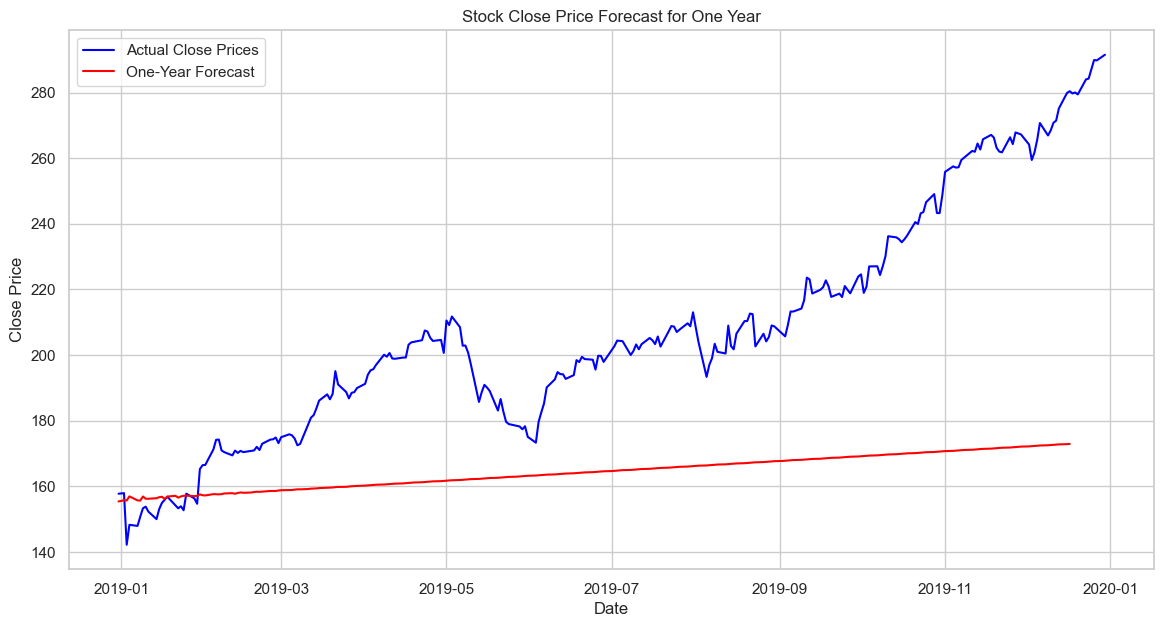

In [567]:
plt.figure(figsize=(14, 7))
plt.plot(test['Close'], label='Actual Close Prices', color='blue')
plt.plot(forecast_index, forecast_org, label='One-Year Forecast', color='red')
plt.title('Stock Close Price Forecast for One Year')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#### ARIMA model is doing very bad

## SARIMA
- Best For: Seasonal data with trends.
- Why: SARIMA builds on ARIMA by adding seasonal elements, making it a robust choice for data with both trend and seasonal patterns (e.g., quarterly or monthly sales data).
- Limitations: Model complexity increases with added parameters for seasonality. It also requires data to be well-behaved (not too noisy) and somewhat consistent in seasonal patterns

In [185]:
p=7
q=6
d=0 # as we already differenced the data
sarimax_model=SARIMAX(train['diff'],order=(p,d,q),seasonal_order=(p,d,q,12),disp=True)
sarimax_model=sarimax_model.fit()
sarimax_model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               diff   No. Observations:                 1758
Model:             SARIMAX(7, 0, 6)x(7, 0, 6, 12)   Log Likelihood               -3611.388
Date:                            Wed, 20 Nov 2024   AIC                           7276.776
Time:                                    17:18:30   BIC                           7424.518
Sample:                                         0   HQIC                          7331.378
                                           - 1758                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7704      0.220     -3.509      0.000      -1.201      -0.340
ar.L2         -0.9348      0.343     -2.727      0.006      -1.606      -0.263
ar.L3         -0.0642      0.463     -0.139      0.890      -0.971       0.843
ar.L4          0.0890      0.429      0.208      0.836      -0.752       0.930
ar.L5          0.3751      0.282      1.331      0.183      -0.177       0.927
ar.L6         -0.0410      0.161     -0.255      0.799      -0.357       0.275
ar.L7          0.1151      0.024      4.877      0.000       0.069       0.161
ma.L1          0.8111      0.222      3.649      0.000       0.375       1.247
ma.L2          0.9312      0.350      2.661      0.008       0.245       1.617
ma.L3          0.0407      0.474      0.086      0.931      -0.887       0.969
ma.L4         -0.1163      0.435     -0.268      0.789      -0.968       0.736
ma.L5         -0.3656      0.280     -1.307      0.191      -0.914       0.183
ma.L6          0.0756      0.164      0.460      0.645      -0.246       0.397
ar.S.L12      -0.6627      1.282     -0.517      0.605      -3.175       1.849
ar.S.L24      -0.3664      0.344     -1.064      0.287      -1.041       0.309
ar.S.L36      -0.0345      0.283     -0.122      0.903      -0.589       0.520
ar.S.L48       0.6267      0.177      3.541      0.000       0.280       0.974
ar.S.L60       0.7960      0.847      0.940      0.347      -0.863       2.455
ar.S.L72       0.4904      0.644      0.761      0.447      -0.773       1.753
ar.S.L84      -0.0028      0.051     -0.056      0.955      -0.102       0.097
ma.S.L12       0.6677      1.277      0.523      0.601      -1.835       3.171
ma.S.L24       0.3233      0.350      0.924      0.356      -0.363       1.009
ma.S.L36       0.0048      0.237      0.020      0.984      -0.459       0.469
ma.S.L48      -0.6165      0.172     -3.579      0.000      -0.954      -0.279
ma.S.L60      -0.8076      0.816     -0.990      0.322      -2.406       0.791
ma.S.L72      -0.4808      0.672     -0.715      0.474      -1.798       0.837
sigma2         3.5495      0.073     48.395      0.000       3.406       3.693
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2461.13
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.31   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [186]:
forecast=sarimax_model.forecast(steps=252)
forecast_org= forecast.cumsum() + df1['Close'].iloc[-252-1]
forecast_index= pd.date_range(start=train.index[-1],periods=forecast_steps+1,freq='B')[1:]

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [188]:
# train predictions
train_predictions=sarimax_model.predict(start=0, end=1757)
train_predictions_org=train_predictions.cumsum()+df1['Close'].iloc[0]

# RMSE
sarima_train_rmse=root_mean_squared_error(train['Close'],train_predictions_org )
sarima_test_rmse=root_mean_squared_error(forecast_org,test['Close'] )
print("RMSE for train of ARIMA Model:",sarima_train_rmse)
print("RMSE for test of ARIMA Model:",sarima_test_rmse)

RMSE for train of ARIMA Model: 79.59609249194001
RMSE for test of ARIMA Model: 65.33441278105134


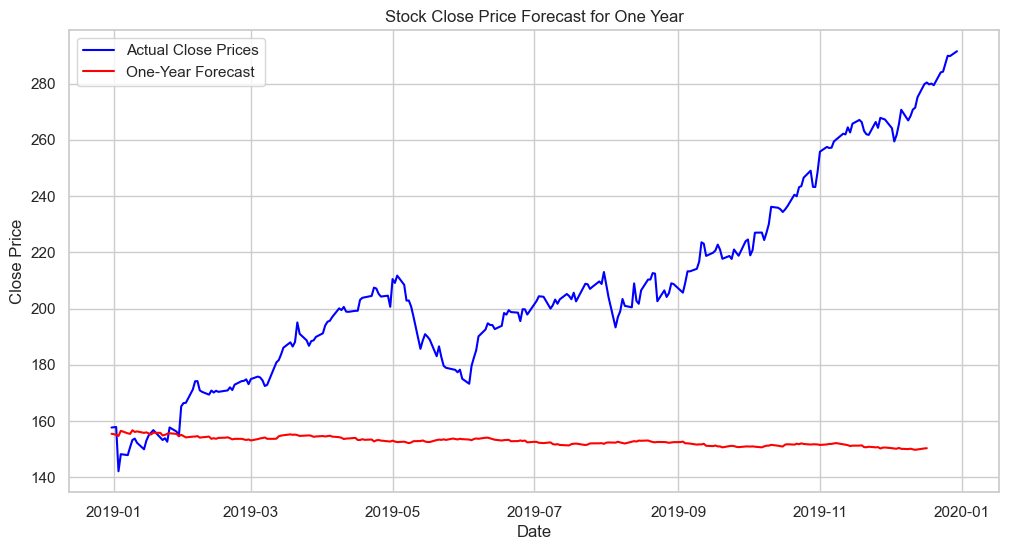

In [571]:
plt.figure(figsize=(12,6))
plt.plot(test['Close'],label='Actual Close Prices',color='blue')
plt.plot(forecast_index,forecast_org,label='One-Year Forecast',color='red')
plt.title('Stock Close Price Forecast for One Year')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#### SARIMAX is also doing bad

## Exponential smoothing:
- Best For: Data with seasonality, trend, and irregular fluctuations.
- Why: Exponential smoothing methods like Holt-Winters use weighted averages to give recent data more importance. This can quickly adjust to changes and capture seasonality and trend without overfitting.
- Limitations: Exponential smoothing doesn’t work well for long-term forecasts with complex seasonality. It also assumes seasonal patterns are constant over time.

In [20]:
# data must be positive for ExSmoothing
train['diff_positive'] = train['diff'] + abs(train['diff'].min()) + 1

In [21]:
ets_model=ExponentialSmoothing(train['diff'],trend='add',seasonal='add',
                                seasonal_periods=30).fit()
ets_model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Dep. Variable:,diff,No. Observations:,1758
Model:,ExponentialSmoothing,SSE,6396.580
Optimized:,True,AIC,2338.609
Trend:,Additive,BIC,2524.655
Seasonal:,Additive,AICC,2340.157
Seasonal Periods:,30,Date:,"Wed, 20 Nov 2024"
Box-Cox:,False,Time:,13:04:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,5.0004e-08,alpha,True
smoothing_trend,1.0622e-12,beta,True


In [22]:
forecast_steps=252
forecast=ets_model.forecast(steps=252)
forecast_org= forecast.cumsum() + df1['Close'].iloc[-252-1]
forecast_index= pd.date_range(start=train.index[-1],periods=forecast_steps+1,freq='B')[1:]

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [189]:
train_predictions=ets_model.predict(start=0, end=1757)
train_predictions_org=train_predictions.cumsum()+df1['Close'].iloc[0]

# RMSE
ets_train_rmse=root_mean_squared_error(train['Close'],train_predictions_org )
ets_test_rmse=root_mean_squared_error(forecast_org,test['Close'] )
print("RMSE for train of ets Model:",ets_train_rmse)
print("RMSE for test of ets Model:",ets_test_rmse)

RMSE for train of ets Model: 23.180178899643263
RMSE for test of ets Model: 65.33441278105134


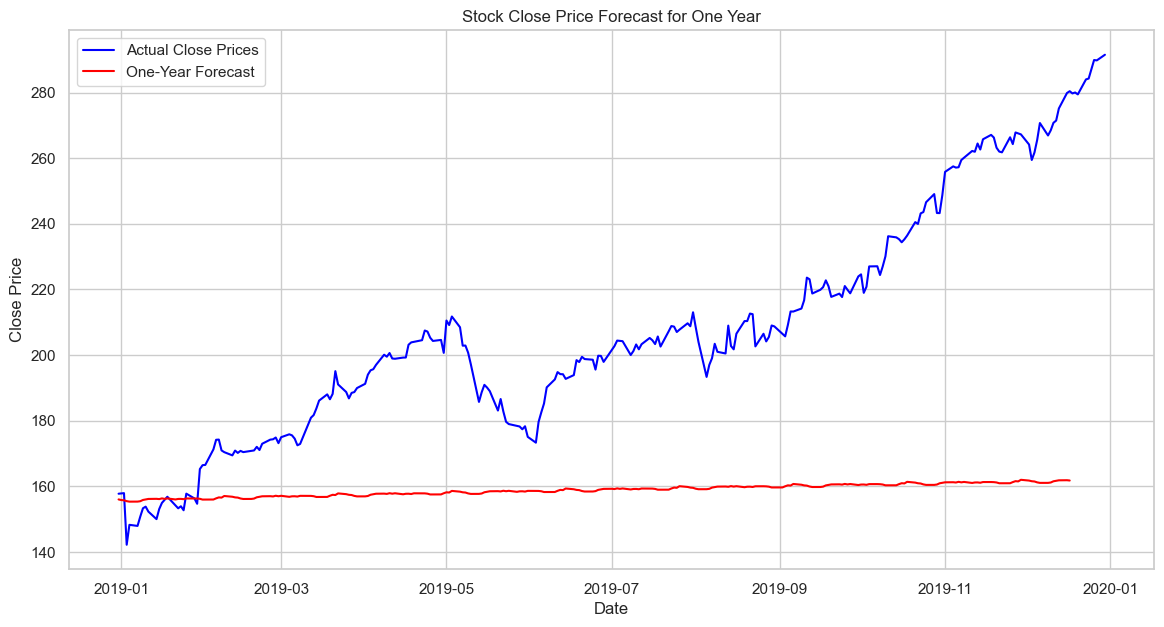

In [579]:
plt.figure(figsize=(14, 7))
plt.plot(test['Close'], label='Actual Close Prices', color='blue')
plt.plot(forecast_index, forecast_org, label='One-Year Forecast', color='red')
plt.title('Stock Close Price Forecast for One Year')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#### Holt winter's Exponential smoothing is giving very bad results

## LSTM (Long Short-Term Memory) Networks
- Best For: Complex, non-linear data with long-range dependencies.
- Why: LSTMs are a type of recurrent neural network (RNN) that can capture long-term dependencies and complex patterns, making them highly effective for large, high-dimensional datasets or very volatile data (e.g., stock price data).
- Limitations: They are computationally intensive, require a large amount of data, and can be prone to overfitting if not regularized well.

In [6]:
# split the data into train and test
train=df1['Close'][:-252].values
# last one year exlcluding weekends considered as test
test=df1['Close'][-252:].values

In [128]:
train.shape, test.shape

((1758,), (252,))

- LSTMs require input data in sequential form, typically as a sliding window of past values to predict future values.
-  For example, to predict the next day’s price, create sequences with a defined window (e.g., 60 past time steps to predict the next value).
-  if we give past 60 value as sequential input then these will not be included in the output set
-  from 60th value of the training data to the end would be the output set
-  len(train)-window_size would be the size of the input set and output set

In [7]:
# Normalizing the data , before normalizing reshaping the data as the scaler needs 2D data
scaler=MinMaxScaler()
train_scaled=scaler.fit_transform(train.reshape(-1,1))
test_scaled=scaler.transform(test.reshape(-1,1))

In [8]:
# function to form an input (sequential form) and output set
def create_dataset(data, time_step=1):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i-time_step:i])   # past 60 steps
        y.append(data[i]) 
    return np.array(x), np.array(y)

In [ ]:
# timestep or window size
time_step = 90

# calling the function and storing the x and y values
train_x, train_y = create_dataset(train_scaled, time_step)
test_x,test_y=create_dataset(test_scaled, time_step)

In [11]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1669, 90, 1), (1669, 1), (162, 90, 1), (162, 1))

### Hyperparameter tuning

In [10]:
#Define the model-building function
def build_model(hp):
    model = Sequential()
    # Input layer with first LSTM
    model.add(LSTM(50, return_sequences=True, input_shape=(60, 1),kernel_regularizer=regularizers.l2(0.01)))
    reg_strength = hp.Choice("reg", [0.01, 0.001, 0.02])
    # Additional LSTM layers with hyperparameters for units and dropout
    for i in range(hp.Int('num_layers', 1, 4)):  
        model.add(LSTM(units=hp.Choice('units', [30, 50, 100, 150]), return_sequences=True,kernel_regularizer=regularizers.l2(reg_strength) ))
        model.add(Dropout(hp.Float('drop', 0.1, 0.5, step=0.1))) 
    # Output layer
    model.add(Dense(1))
    
    learning_rate = hp.Choice('lr', [0.001, 0.01, 0.1])
    
    # Select optimizer based on string, then apply chosen learning rate
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'adadelta'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model


In [11]:

# Initialize the RandomSearch tuner
tuner=RandomSearch(build_model,objective='val_loss', max_trials=10, directory='my_dir',project_name='keras-tuner-train-data')

# hyperparameter search
tuner.search(train_x,train_y, validation_data=(test_x,test_y),epochs=20)

Reloading Tuner from my_dir/keras-tuner-train-data/tuner0.json


In [12]:
tuner.get_best_hyperparameters()[0].values

{'reg': 0.001,
 'num_layers': 1,
 'units': 50,
 'drop': 0.30000000000000004,
 'lr': 0.01,
 'optimizer': 'adam'}

In [ ]:
# final model build
best_model=Sequential()
best_model.add(LSTM(50, return_sequences=True, input_shape=(90, 1),kernel_regularizer=regularizers.l2(0.01)))
best_model.add(Dropout(0.5))
best_model.add(LSTM(50, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)))
best_model.add(Dropout(0.4))

best_model.add(Dense(1))

optimizer = SGD(learning_rate=0.01)
best_model.compile(optimizer=optimizer, loss='mean_squared_error')


#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
best_model.fit(train_x, train_y, validation_data=(test_x, test_y), 
                epochs=30, callbacks=[early_stopping])


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.1198 - val_loss: 0.1065
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0871 - val_loss: 0.0931
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0822 - val_loss: 0.0851
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0787 - val_loss: 0.0792
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0755 - val_loss: 0.0795
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0735 - val_loss: 0.0782
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0750 - val_loss: 0.0684
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0708 - val_loss: 0.0889
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0681 - val_loss: 0.0651
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0647 - val_loss: 0.0711
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0624 - val_loss: 0.0726
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0

In [152]:
# predictions 
train_pred=best_model.predict(train_x)
test_pred=best_model.predict(test_x)
train_pred

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[0.23630592],
       [0.23470324],
       [0.23297507],
       ...,
       [0.72939587],
       [0.72080684],
       [0.71268916]], dtype=float32)

In [153]:
train_y

array([[0.13589579],
       [0.13180328],
       [0.12605756],
       ...,
       [0.57510775],
       [0.56932147],
       [0.56977531]])

In [154]:
# reverse scaling the prediction values
train_pred_org=scaler.inverse_transform(train_pred)
test_pred_org=scaler.inverse_transform(test_pred)

In [155]:
# prediction in original form
train_pred_org

array([[ 97.446014],
       [ 97.16348 ],
       [ 96.85884 ],
       ...,
       [184.36792 ],
       [182.85384 ],
       [181.42285 ]], dtype=float32)

In [156]:
# original values
train[90:].reshape(-1,1)

array([[ 79.745712],
       [ 79.024284],
       [ 78.011429],
       ...,
       [157.169998],
       [156.149994],
       [156.229996]])

In [162]:
lstm_train_rmse=root_mean_squared_error(train[90:], train_pred_org)
lstm_test_rmse=root_mean_squared_error(test[90:], test_pred_org)
print("Train RMSE:",lstm_train_rmse)
print("Test RMSE:",lstm_test_rmse)

Train RMSE: 14.051702731130126
Test RMSE: 11.909344609039382


In [158]:
# from 2D to 1D
train_pred_org.ravel().shape

(1668,)

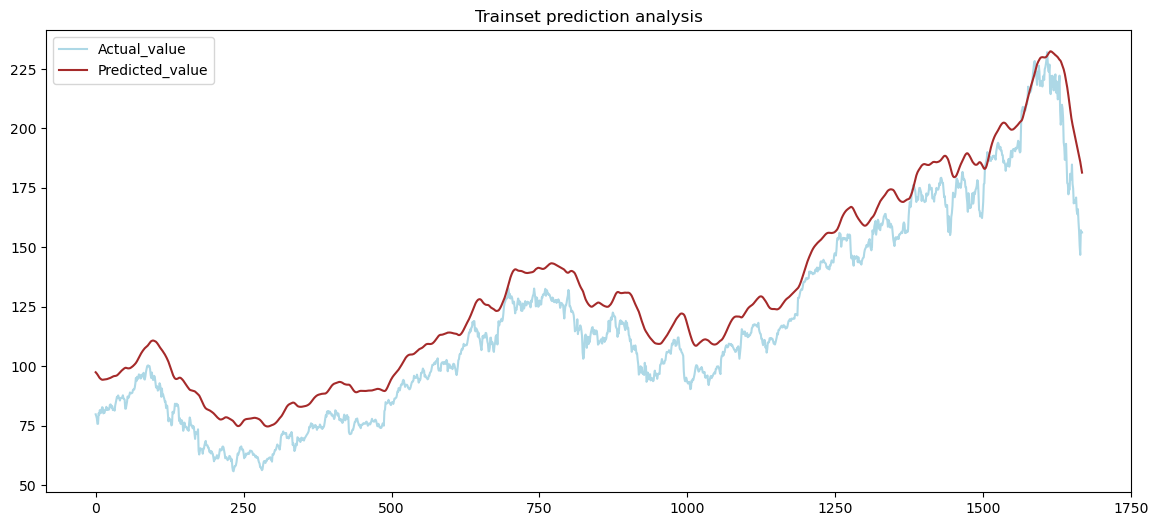

In [163]:
plt.figure(figsize=(14,6))
sns.lineplot(y=train[90:],x=range(len(train[90:])), label='Actual_value', color='lightblue')
sns.lineplot(y=train_pred_org.ravel(),x=range(len(train_pred_org)), label='Predicted_value', color='brown')
plt.title('Trainset prediction analysis')
plt.legend()
plt.show()

In [222]:
test[90:].shape,test_pred_org.shape

((162,), (162, 1))

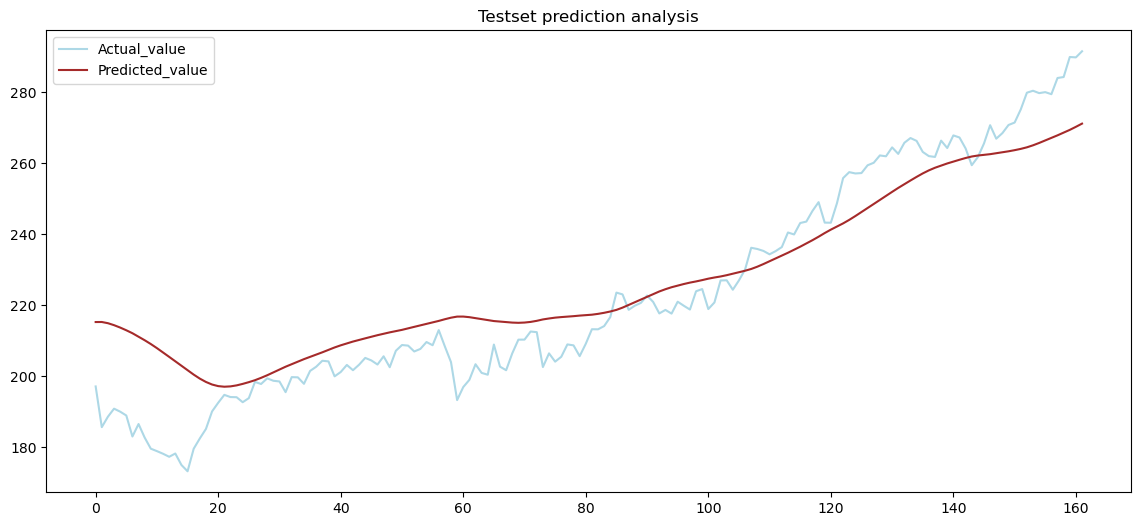

In [166]:
plt.figure(figsize=(14,6))
sns.lineplot(y=test[90:],x=range(len(test[90:])), label='Actual_value', color='lightblue')
sns.lineplot(y=test_pred_org.ravel(),x=range(len(test_pred_org)), label='Predicted_value', color='brown')
plt.title('Testset prediction analysis')
plt.legend()
plt.show()

In [256]:
# Analysis of RMSE values of different models
models=['Arima','Sarima','ExponentialS','LSTM']
trainRmse=[arima_train_rmse, sarima_train_rmse,ets_train_rmse, lstm_train_rmse]
testRmse=[arima_test_rmse,sarima_test_rmse,ets_test_rmse, lstm_test_rmse]
Models_rmse=pd.DataFrame({'TrainRMSE':trainRmse, 'TestRMSE':testRmse}, index=models)
Models_rmse

,TrainRMSE,TestRMSE
Arima,19.468333,52.522263
Sarima,79.596092,65.334413
ExponentialS,23.180179,65.334413
LSTM,11.646511,11.434510


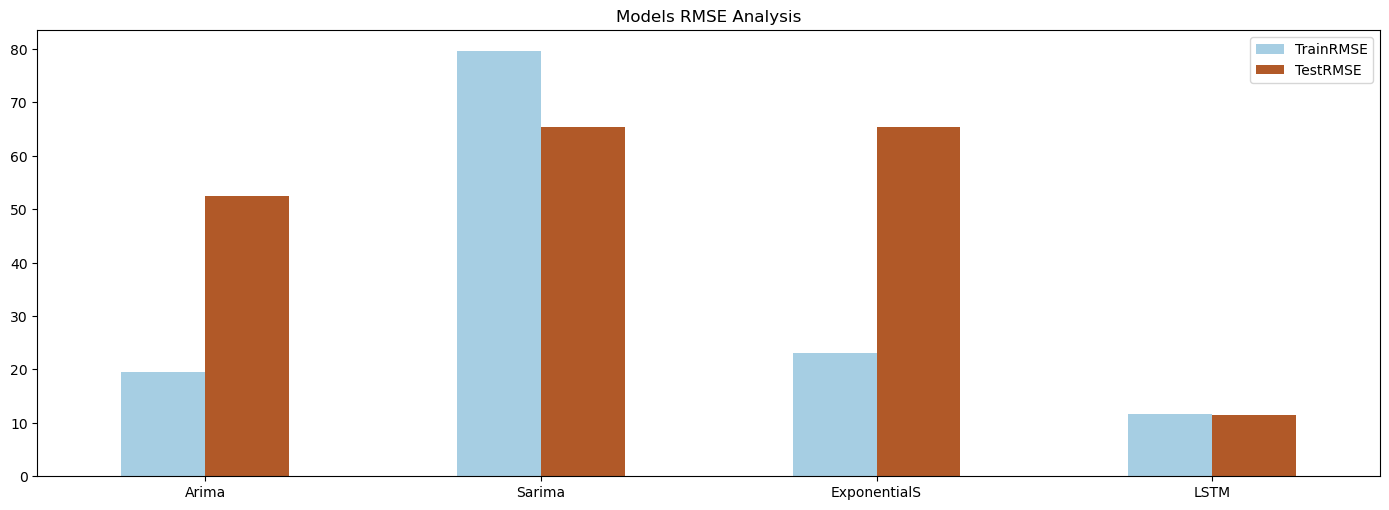

In [316]:
Models_rmse.plot(kind='bar',figsize=(14,5),colormap='Paired')
plt.xticks(rotation=360)
plt.tight_layout()
plt.title('Models RMSE Analysis')
plt.show()

In [167]:
df1['Close']

Date
2012-01-04     59.062859
2012-01-05     59.718571
2012-01-06     60.342857
2012-01-09     60.247143
2012-01-10     60.462856
                 ...    
2019-12-23    284.000000
2019-12-24    284.269989
2019-12-26    289.910004
2019-12-27    289.799988
2019-12-30    291.519989
Name: Close, Length: 2010, dtype: float64

# Final model on complete data

In [13]:
# transforming the original data
time_step=90
data_x, data_y = create_dataset(df1['Close'], time_step)
scaler_x=MinMaxScaler()
scaler_y=MinMaxScaler()
X=scaler_x.fit_transform(data_x)
Y=scaler_y.fit_transform(data_y.reshape(-1,1))

X_scaled= X.reshape(X.shape[0], X.shape[1], 1)

In [17]:
X_scaled.shape, Y.shape

((1921, 90, 1), (1921, 1))

In [14]:
# Initialize the RandomSearch tuner
tuner=RandomSearch(build_model,objective='val_loss', max_trials=10, directory='my_dir',project_name='keras-tuner-complete-data')

# hyperparameter search
tuner.search(X_scaled,Y, validation_split=0.3,epochs=30)

Reloading Tuner from my_dir/keras-tuner-complete-data/tuner0.json


In [ ]:
tuner.results_summary()

In [16]:
# best hyperparameters
tuner.get_best_hyperparameters()[0].values

{'reg': 0.001,
 'num_layers': 4,
 'units': 150,
 'drop': 0.5,
 'lr': 0.001,
 'optimizer': 'adam'}

In [13]:
# final model build
final_model=Sequential()
final_model.add(LSTM(150, return_sequences=True, input_shape=(90, 1),kernel_regularizer=regularizers.l2(0.001)))
final_model.add(Dropout(0.5))
final_model.add(LSTM(150, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))
final_model.add(Dropout(0.5))
final_model.add(LSTM(150, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))
final_model.add(Dropout(0.5))
final_model.add(LSTM(150, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)))
final_model.add(Dropout(0.5))


final_model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='mean_squared_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
final_model.fit(X_scaled, Y, validation_split=0.3, 
                epochs=50, callbacks=[early_stopping])

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 389ms/step - loss: 0.5465 - val_loss: 0.1686
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - loss: 0.1146 - val_loss: 0.0489
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - loss: 0.0216 - val_loss: 0.0115
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - loss: 0.0035 - val_loss: 0.0145
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 372ms/step - loss: 0.0030 - val_loss: 0.0093
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 373ms/step - loss: 0.0026 - val_loss: 0.0126
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - loss: 0.0029 - val_loss: 0.0050
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 385ms/step - loss: 0.0020 - val_loss: 0.0072
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 382ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - loss: 0.0022 - val_loss: 0.0051
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 21

In [14]:
predictions=final_model.predict(X_scaled)

predictions_unscaled=scaler_y.inverse_transform(predictions)
root_mean_squared_error(predictions_unscaled,data_y)

61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step


np.float64(9.59997707699323)

In [15]:
mean_squared_error(predictions_unscaled,data_y)

np.float64(92.1595598787955)

In [16]:
predictions

array([[0.12135114],
       [0.11877303],
       [0.11612797],
       ...,
       [0.81567794],
       [0.8164407 ],
       [0.8174272 ]], dtype=float32)

In [17]:
Y

array([[0.10676864],
       [0.10162352],
       [0.09856312],
       ...,
       [0.99317022],
       [0.99270351],
       [1.        ]])

In [18]:
type(data_y),type(predictions_unscaled)

(numpy.ndarray, numpy.ndarray)

In [19]:
#original values
data_y[-30:]

array([265.76001 , 267.100006, 266.290009, 263.190002, 262.01001 ,
       261.779999, 266.369995, 264.290009, 267.839996, 267.25    ,
       264.160004, 259.450012, 261.73999 , 265.579987, 270.709991,
       266.920013, 268.480011, 270.769989, 271.459991, 275.149994,
       279.859985, 280.410004, 279.73999 , 280.019989, 279.440002,
       284.      , 284.269989, 289.910004, 289.799988, 291.519989])

In [20]:
# predictions
predictions_unscaled.ravel()[-30:]

array([233.02107, 234.12096, 235.20581, 236.2652 , 237.3002 , 238.30681,
       239.27661, 240.20816, 241.09586, 241.93054, 242.7107 , 243.4386 ,
       244.11299, 244.72519, 245.27284, 245.75223, 246.1741 , 246.53609,
       246.8422 , 247.08838, 247.28119, 247.42737, 247.54424, 247.63922,
       247.72844, 247.8236 , 247.93268, 248.06976, 248.24956, 248.48212],
      dtype=float32)

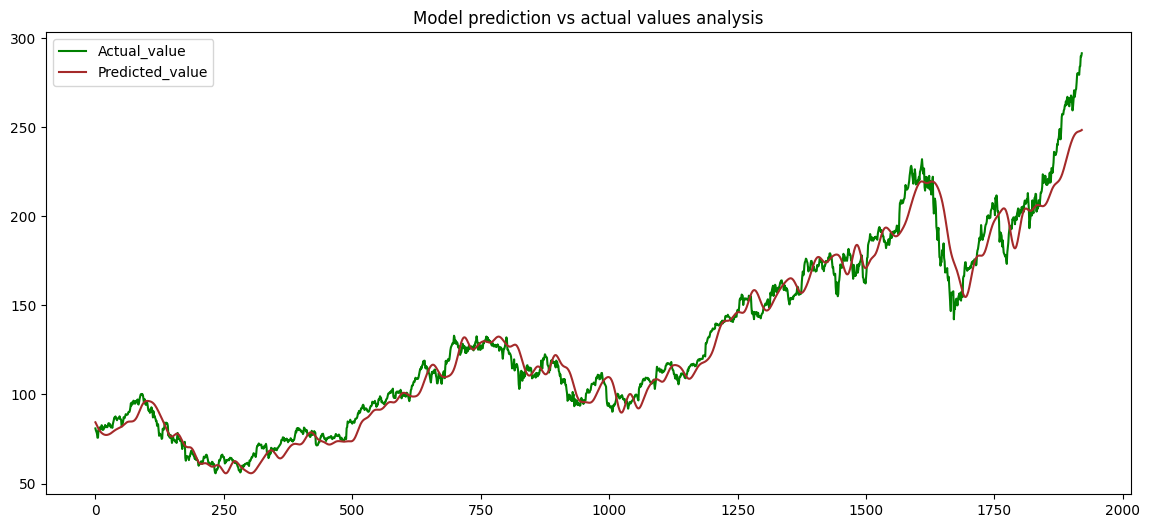

In [21]:
plt.figure(figsize=(14,6))
sns.lineplot(y=data_y,x=range(len(data_y)), label='Actual_value', color='green')
sns.lineplot(y=predictions_unscaled.ravel(),x=range(len(predictions_unscaled)), label='Predicted_value', color='brown')
plt.title('Model prediction vs actual values analysis')
plt.legend()
plt.show()

# Forecasting for next 30 days

In [23]:
last_sequence=X_scaled[-1].reshape(1,-1)

last_sequence=np.expand_dims(last_sequence, -1)

steps=30
forecasts=[]
for _ in range(steps):
    next_pred=final_model.predict(last_sequence)[0][0]
    forecasts.append(next_pred)
    next_input = np.array(next_pred).reshape(1, 1, 1)
    last_sequence=np.append(last_sequence[:,1:,:],next_input,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

In [24]:
forecasts_unscaled=scaler_y.inverse_transform(np.array(forecasts).reshape(-1, 1))
forecasts_unscaled

array([[248.48212],
       [248.5474 ],
       [248.62189],
       [248.69577],
       [248.74832],
       [248.7624 ],
       [248.71503],
       [248.58215],
       [248.34172],
       [247.9716 ],
       [247.44963],
       [246.76053],
       [245.89496],
       [244.8475 ],
       [243.61937],
       [242.2185 ],
       [240.66183],
       [238.96947],
       [237.16551],
       [235.28004],
       [233.34628],
       [231.39938],
       [229.47339],
       [227.6007 ],
       [225.81187],
       [224.13246],
       [222.58449],
       [221.18202],
       [219.93155],
       [218.83603]], dtype=float32)

In [33]:
with open("scaler", 'wb') as file:
    pickle.dump(scaler_y, file)

with open ("X_scaled", 'wb') as file:
    pickle.dump(X_scaled, file)

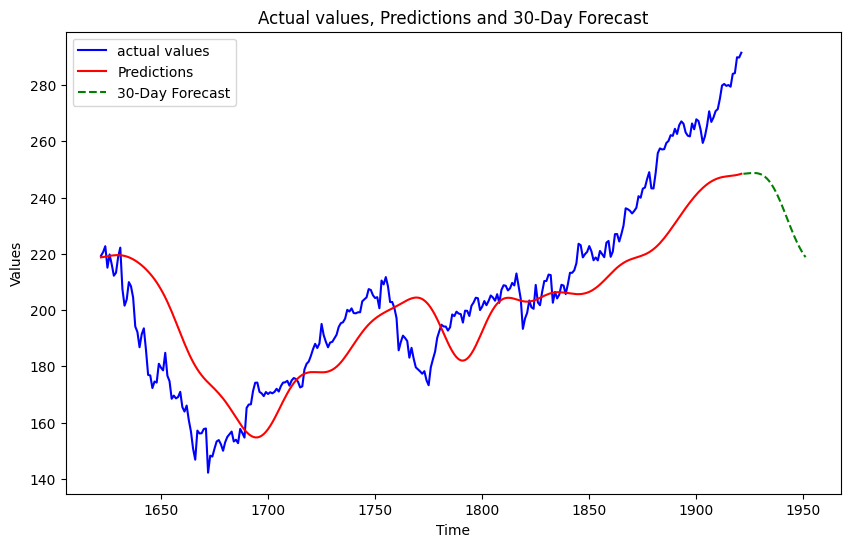

In [25]:

original_index = np.arange(1, len(data_y.ravel()) + 1)

forecast_index = np.arange(len(predictions_unscaled.ravel()) + 1, 
                            len(predictions_unscaled.ravel()) + len(forecasts_unscaled) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(original_index[-300:], data_y[-300:].ravel(), label='actual values', color='blue')

plt.plot(original_index[-300:], predictions_unscaled[-300:], label='Predictions', color='red')

plt.plot(forecast_index,forecasts_unscaled, label='30-Day Forecast', color='green', linestyle='--')

# Adding details
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual values, Predictions and 30-Day Forecast')
plt.legend()
#plt.grid(True)
plt.show()


In [26]:
import pickle
with open("lstm_model.pkl", 'wb') as file:
    pickle.dump(final_model,file)